In [1]:
import numpy as np
from helpers import make_data
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
from helpers import display_world

%matplotlib inline

In [2]:
def initialize_constraints(N, num_landmarks, world_size):
    ''' This function takes in a number of time steps N, number of landmarks, and a world_size,
        and returns initialized constraint matrices, omega and xi.'''
    
    rows = 2*N + 2*num_landmarks
    cols = rows
    
    omega = np.zeros((rows, cols))
    omega[:2, :2] += np.array([[1, 0],
                               [0, 1]])
    
    xi = np.zeros((rows,))
    xi[:2] += world_size/2
    
    return omega, xi
    

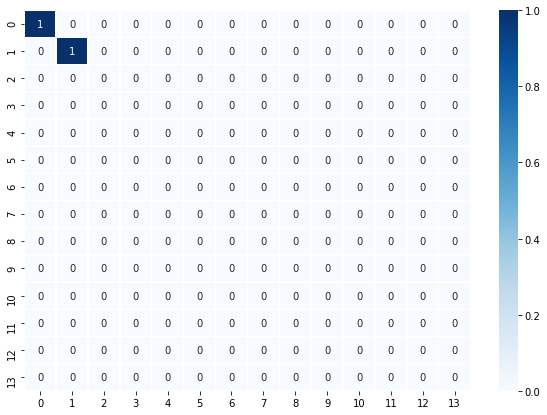

In [3]:
N_test = 5
num_landmarks_test = 2
small_world = 10

# initialize the constraints
initial_omega, initial_xi = initialize_constraints(N_test, num_landmarks_test, small_world)

plt.rcParams["figure.figsize"] = (10,7)
sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)

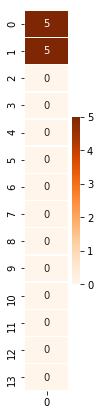

In [4]:
plt.rcParams["figure.figsize"] = (1,7)
sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)

In [43]:
data[0][0]

[[0, -47.504558435235474, 46.951147361935305],
 [1, 44.42369419256923, 25.69846303788409],
 [2, 43.613801664892456, 27.433554103391657],
 [3, 12.56013623388057, 23.833238975741015],
 [4, 40.07686306651211, 18.39580068175173]]

In [5]:
def slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise):
    
    omega, xi = initialize_constraints(N, num_landmarks, world_size)
    
    for i in range(len(data)):
        measurements = data[i][0]
        motion = data[i][1]
       
        for ms in measurements:
            landmark_idx = ms[0]
            x = ms[1]
            y = ms[2]
            
            # add/substract noise for all X_Pos and X_Landmark values
            
            # X-L = +?
            # X_pos is found at each 2 cells
            omega[2*i, 2*i] += 1 / measurement_noise
            # X_LandMarks can ben found at 2*Nstep idx, then each 2 cells
            omega[2*i, 2*N + 2*landmark_idx] += -1 / measurement_noise        
            
            # L-X = -?
            # Landmark according to the 
            omega[2*N + 2*landmark_idx, 2*i] += -1 / measurement_noise
            # Landmark according to itself
            omega[2*N + 2*landmark_idx, 2*N + 2*landmark_idx] += 1 / measurement_noise
            
            # update the xi value for the X_Pos & Lx
            xi[2*i] += -x / measurement_noise
            xi[2*N + 2*landmark_idx] += x / measurement_noise
            
            
            # SAME THINGS FOR Y_Pos and Ly (just add +1 on indices)
            
            omega[2*i + 1, 2*i + 1] += 1 / measurement_noise
            omega[2*i + 1, 2*N + 2*landmark_idx + 1] += -1 / measurement_noise
            omega[2*N + 2*landmark_idx + 1, 2*i + 1] += -1 / measurement_noise
            omega[2*N + 2*landmark_idx + 1, 2*N + 2*landmark_idx + 1] += 1 / measurement_noise

            xi[2*i + 1] += -y / measurement_noise
            xi[2*N + 2*landmark_idx + 1] += y / measurement_noise
            
        
        # EXACTE SAME THINGS FOR MOTION : BUT between X and X+2 ; Y and Y+2 which is the same things as X+1 and X+3
        dx, dy = motion[0], motion[1]
        omega[2*i, 2*i] += 1 / motion_noise
        omega[2*i, 2*i + 2] += -1 / motion_noise
        omega[2*i + 2, 2*i] += -1 / motion_noise
        omega[2*i + 2, 2*i + 2] += 1 / motion_noise

        omega[2*i + 1, 2*i + 1] += 1 / motion_noise
        omega[2*i + 1, 2*i + 3] += -1 / motion_noise
        omega[2*i + 3, 2*i + 1] += -1 / motion_noise
        omega[2*i + 3, 2*i + 3] += 1 / motion_noise
        
        xi[2*i] += -dx / motion_noise
        xi[2*i + 2] += dx / motion_noise
        xi[2*i + 1] += -dy / motion_noise
        xi[2*i + 3] += dy / motion_noise
        
    mu = np.dot(np.linalg.inv(omega), xi)
    
    return mu # return `mu`


In [34]:
def get_poses_landmarks(mu, N):
    """
    This function iterate over the mu matrix N times
    to get the x and y position of the robot.
    Then iterate over the rest of the list to get
    all the Landmarks positions.
    
    Example:
    For N=20 steps time
    We iterate from 0-19 to get all the positions
    of the robot
    
    Then From 20 to the rest to get the Landmark positions
    """
    poses = []
    for i in range(N):
        # get all the (x, y) poses
        poses.append((mu[2*i].item(), mu[2*i+1].item()))

    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))

    return poses, landmarks


In [7]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')


In [8]:
# World Params
num_landmarks      = 5        # number of landmarks
N                  = 20       # time steps
world_size         = 100.0    # size of world (square)

# robot parameters
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 

data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[2, 96], [93, 75], [95, 76], [64, 73], [91, 70]]
Robot: [x=72.60208 y=79.85855]


In [9]:
mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)

if(mu is not None):
    poses, landmarks = get_poses_landmarks(mu, N)
    print_all(poses, landmarks)
    



Estimated Poses:
[50.000, 50.000]
[62.856, 63.875]
[76.730, 76.953]
[92.421, 90.632]
[73.529, 93.619]
[54.079, 94.239]
[33.393, 95.659]
[11.502, 98.547]
[24.490, 83.945]
[36.807, 67.983]
[50.189, 51.808]
[64.051, 38.349]
[77.329, 24.977]
[90.872, 11.280]
[73.320, 2.089]
[78.671, 22.099]
[84.023, 42.109]
[88.347, 61.041]
[93.908, 81.413]
[73.922, 80.656]


Estimated Landmarks:
[2.269, 96.903]
[93.235, 75.123]
[94.793, 76.790]
[63.883, 73.388]
[90.500, 70.147]


Last pose:  (60.86100011526081, 39.355578252838484)


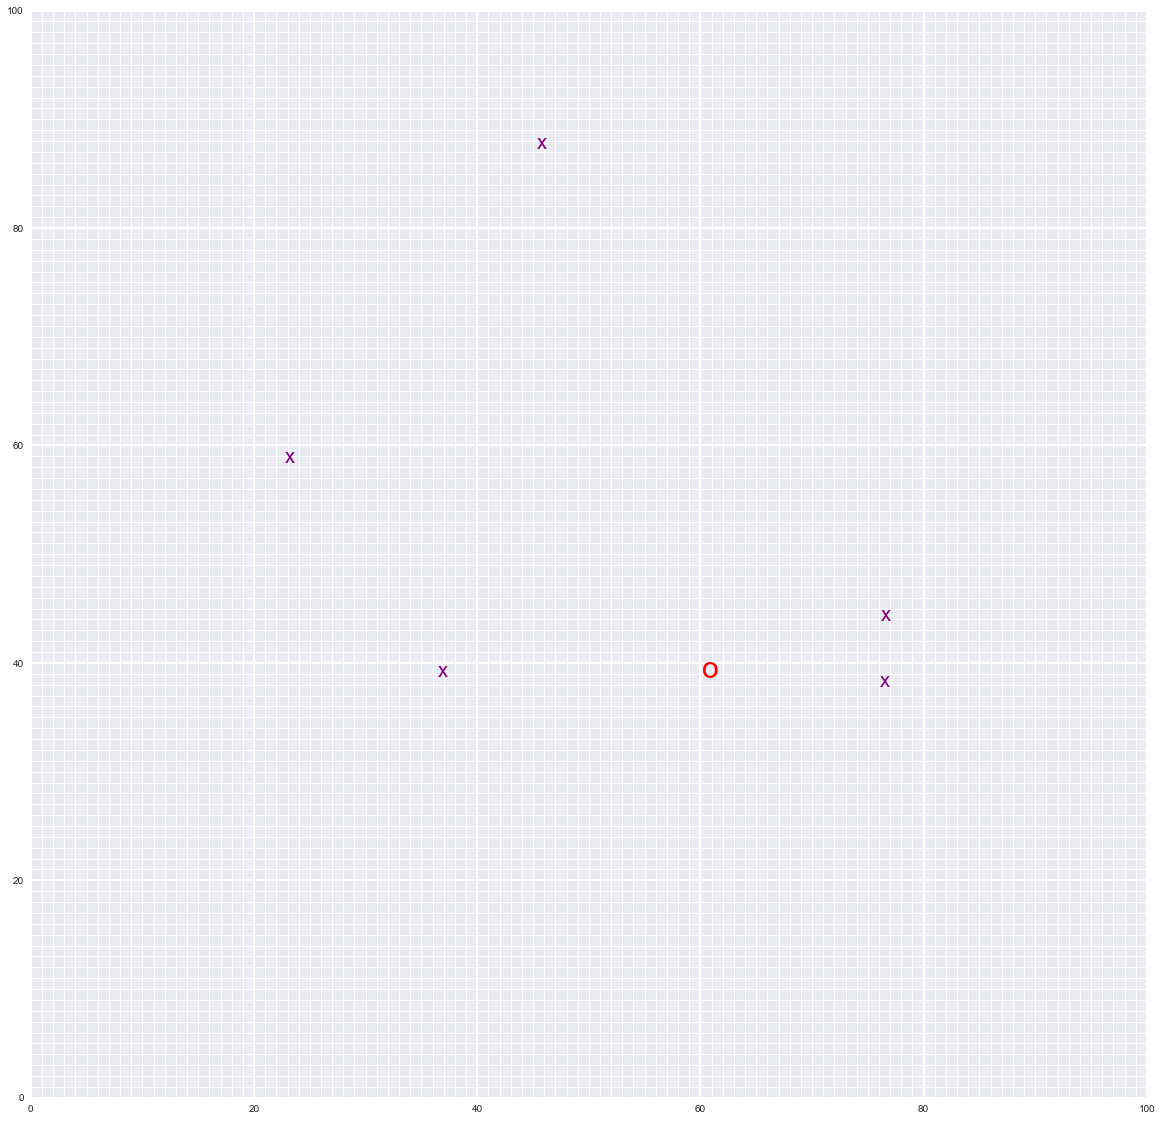

In [11]:
plt.rcParams["figure.figsize"] = (20,20)

# check if poses has been created
if 'poses' in locals():
    # print out the last pose
    print('Last pose: ', poses[-1])
    # display the last position of the robot *and* the landmark positions
    display_world(int(world_size), poses[-1], landmarks)

Once We have our matrices, we have to fill both OMEGA AND XI by doing:

`robot_positions = [[x0, y0]]`

> MOVE

Say we have a mvt from (xy0) to (xy1) by after 5 rotation wheels   
We know xy1 is 5 rotation wheels far from xy0  
So We populate OMEGA and Xi  
We compute the Mu matrix to get the position xy1  
We append the position xy1 in our array  
`robot_positions = [ [x0, y0], [x1, y1] ]`

THEN WE SENSE FROM x1y1 Position  
We detect a landmark 8m away  
We populate OMEGA and Xi  

THEN WE MOVE  
And so one  